# Model Random Forest using LightGBM
 Using aggregated invoice data


In [1]:
# Used for filename when saving model
model_name = "LightLGB agg-data v1"

In [2]:
import pandas as pd
import numpy as np

import pyarrow
import fastparquet

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

#from lightgbm import LGBMClassifier
#from sklearn.ensemble import RandomForestClassifier

#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, f1_score, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score

# for saving model to disk
import time
from skops.io import dump, load, get_untrusted_types

import lightgbm as lgb  # LightGBM version 4.6.0
from lightgbm import early_stopping  # Import early_stopping callback

## Run data cleaning script, generate parquet files. 
Requires pyarrow and fastparquet (see requirements.txt)

In [3]:
# Open and run **ETL_export_parquet_invoice-level_+_client-level_mean.py**

## Import parquet files

In [4]:
# Import clean data 
# - Each row represents one invoice.
df_train_non_agg = pd.read_parquet("data/df_train_non_agg.parquet")
df_final_test_non_agg = pd.read_parquet("data/df_final_test_non_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

# Import clean data
# - Each row represents one client. 
# - Invoices are summarised. 
# - The "consommation_level_x" columns show mean energy consumption per client.
df_train_agg = pd.read_parquet("data/df_train_agg.parquet")
df_final_test_agg = pd.read_parquet("data/df_final_test_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

In [5]:
df_train_non_agg

,creation_date,target,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,months_number,counter_type_ELEC,counter_type_GAZ,...,counter_code_450,counter_code_453,counter_code_467,counter_code_483,counter_code_5,counter_code_506,counter_code_532,counter_code_565,counter_code_600,counter_code_65
0,34699,0,1.0,82.0,0.0,0.0,0.0,4,True,False,...,False,False,False,False,False,False,False,False,False,False
1,34699,0,1.0,1200.0,184.0,0.0,0.0,4,True,False,...,False,False,False,False,False,False,False,False,False,False
2,34699,0,1.0,123.0,0.0,0.0,0.0,4,True,False,...,False,False,False,False,False,False,False,False,False,False
3,34699,0,1.0,102.0,0.0,0.0,0.0,4,True,False,...,False,False,False,False,False,False,False,False,False,False
4,34699,0,1.0,572.0,0.0,0.0,0.0,12,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430783,40869,0,1.0,118.0,0.0,0.0,0.0,4,False,True,...,False,False,False,False,True,False,False,False,False,False
4430784,40869,0,1.0,312.0,0.0,0.0,0.0,4,True,False,...,False,False,False,False,False,False,False,False,False,False
4430785,40869,0,1.0,578.0,0.0,0.0,0.0,4,True,False,...,False,False,False,False,False,False,False,False,False,False
4430786,34325,0,1.0,400.0,135.0,0.0,0.0,8,True,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# Choose dataset to use in this document
df = df_train_agg
df_final_test = df_final_test_agg

In [7]:
df.head()

,creation_date,target,transactions_count,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,counter_type_GAZ,counter_type_ELEC,...,counter_code_450,counter_code_453,counter_code_467,counter_code_483,counter_code_5,counter_code_506,counter_code_532,counter_code_565,counter_code_600,counter_code_65
0,34699,0,35,1.0,352.400000,10.571429,0.000000,0.000000,False,True,...,False,False,False,False,False,False,False,False,False,False
1,37405,0,37,1.0,557.540541,0.000000,0.000000,0.000000,False,True,...,False,False,False,False,False,False,False,False,False,False
2,31484,0,18,1.0,798.611111,37.888889,0.000000,0.000000,False,True,...,False,False,False,False,False,False,False,False,False,False
3,35257,0,20,1.0,1.200000,0.000000,0.000000,0.000000,False,True,...,False,False,False,False,False,False,False,False,False,False
4,41926,0,14,1.0,663.714286,104.857143,117.357143,36.714286,False,True,...,False,False,False,False,False,False,False,False,False,False


In [8]:
df.describe()

,creation_date,target,transactions_count,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,reading_remarque,counter_statue
count,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000
mean,37801.779602,0.059078,34.615531,1.001211,407.277247,117.619880,27.496823,75.918575,8.781734,0.010695
std,4107.568660,0.235772,25.782890,0.183005,342.787037,756.054243,96.626119,833.338704,0.726306,0.160331
min,28161.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000
25%,34858.000000,0.000000,13.000000,1.000000,220.530312,0.000000,0.000000,0.000000,9.000000,0.000000
50%,39018.500000,0.000000,31.500000,1.000000,355.161002,6.892857,0.000000,0.000000,9.000000,0.000000
75%,41108.000000,0.000000,52.000000,1.000000,533.078947,66.688702,5.560244,0.000000,9.000000,0.000000
max,43718.000000,1.000000,434.000000,40.000000,34024.000000,115683.000000,2400.000000,79179.777778,9.000000,5.000000


## Split Data to Train and Test

In [9]:
# Make sure final_test has same dummy columns in as training data (filled with False)
def add_missing_dummy_columns_and_fill_false(train, final_test): 

    cols_missing_from_final_test = (set(train) - set(final_test)) - set(['target'])

    for cols in cols_missing_from_final_test:   
        final_test[cols] = False
    print(f"Adding new cols to final_test: {cols_missing_from_final_test}")

add_missing_dummy_columns_and_fill_false(df, df_final_test)

Adding new cols to final_test: {'counter_code_305', 'region_199', 'counter_code_307'}


In [10]:
X = df.loc[:, ~df.columns.isin(["target"])]
y = df["target"]
X_final_test = df_final_test

# make sure column order the same in X and X_final_test
X, X_final_test = X.align(X_final_test, join="right", axis=1)

RSEED = 42

# 30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=RSEED
)


### Balance Classes

In [11]:

## Balance classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train,y_train)

## Imputing missing values

In [12]:
# % of missing values for each column in Training data
(100 * df.isnull().sum() / df.count()).sort_values(ascending=False)

creation_date       0.0
tarif_type_11       0.0
counter_code_214    0.0
counter_code_210    0.0
counter_code_207    0.0
                   ... 
region_302          0.0
region_301          0.0
region_206          0.0
region_199          0.0
counter_code_65     0.0
Length: 89, dtype: float64

In [13]:
# % of missing values for each column in the final test data. Compare with training data above to see if similar proportion.
(100 * df_final_test.isnull().sum() / df_final_test.count()).sort_values(ascending=False)

creation_date         0.0
transactions_count    0.0
counter_code_222      0.0
counter_code_214      0.0
counter_code_210      0.0
                     ... 
region_303            0.0
region_302            0.0
region_301            0.0
region_206            0.0
counter_code_307      0.0
Length: 88, dtype: float64

In [14]:
# What does the data look like for rows with missing data
df_missing_values = df[pd.isnull(df["transactions_count"]) == True]

In [15]:
X_train_resampled

,creation_date,transactions_count,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,counter_type_GAZ,counter_type_ELEC,reading_remarque,...,counter_code_483,counter_code_5,counter_code_506,counter_code_532,counter_code_565,counter_code_600,counter_code_65,counter_code_305,region_199,counter_code_307
0,38240,22,1.0,403.363636,0.000000,0.000000,0.000000,True,True,9,...,False,False,False,False,False,False,False,False,False,False
1,36136,26,1.0,964.730769,0.000000,0.000000,0.000000,True,True,9,...,False,False,False,False,False,False,False,False,False,False
2,28458,30,1.0,2598.300000,91.000000,0.000000,0.000000,False,True,8,...,False,False,False,False,False,False,False,False,False,False
3,40522,4,1.0,1339.750000,174.500000,0.000000,0.000000,False,True,8,...,False,False,False,False,False,False,False,False,False,False
4,39233,63,1.0,159.301587,0.000000,0.000000,0.000000,True,True,9,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168609,30404,53,1.0,762.905660,141.358491,9.528302,0.000000,True,True,9,...,False,False,False,False,False,False,False,False,False,False
168610,39801,52,1.0,246.442308,5.442308,0.000000,0.000000,True,True,9,...,False,False,False,False,False,False,False,False,False,False
168611,31201,26,1.0,639.000000,352.076923,30.769231,84.846154,True,True,9,...,False,False,False,False,False,False,False,False,False,False
168612,32976,40,1.0,314.300000,30.725000,16.550000,0.000000,True,True,9,...,False,True,False,False,False,False,False,False,False,False


In [16]:
y_train_resampled.value_counts()

target
0    84307
1    84307
Name: count, dtype: int64

In [17]:
# pipeline

# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
cat_features = list(X_train_resampled.columns[X_train_resampled.dtypes==object])

num_features = list(X_train_resampled.columns[X_train_resampled.dtypes!=object])

from sklearn.pipeline import Pipeline

# Pipeline for numeric features 
num_transformer = Pipeline([
    ('imputer_num', SimpleImputer(missing_values=0, strategy='mean')), # replace 0 with means 
   # ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_transformer = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
   # ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
],
    n_jobs=8)

# Train Model

In [18]:
import lightgbm as lgb
print(lgb.__version__)  # Ensure LightGBM version is correct

4.6.0


In [19]:
# Initialize the model (LGBMClassifier with GPU)
gbm = lgb.LGBMClassifier()

# Estimator for use in random search
#estimator = RandomForestClassifier(random_state = RSEED)

# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', gbm)
])

param_grid = {
      'classifier__objective': ['binary'],                    # Binary classification problem
      'classifier__boosting_type' : ['gbdt'],                 # Gradient Boosting Decision Trees
      'classifier__device' : ['gpu'],                         # Use GPU for faster training
      'classifier__gpu_platform_id' : [0],                    # GPU platform ID (in case of multiple GPUs)     
      'classifier__gpu_device_id' : [0],                      # Specific GPU ID
      'classifier__is_unbalance' : [True],                    # Handle imbalanced data
      'classifier__learning_rate' : [0.01, 0.05, 0.1],        # Learning rate (step size)
      'classifier__num_leaves' : [31, 63, 127],               # Maximum number of leaves per tree
      'classifier__max_depth' : [-1, 5, 10],                  # No limit on tree depth
      'classifier__min_data_in_leaf' : [10, 20, 50],          # Minimum number of samples in each leaf
      'classifier__verbose' : [-1],                           # Suppress excessive output
      'classifier__n_estimators' : [500, 1000, 1500]          # Maximum number of boosting rounds (trees)
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Optimize for F1 score
    n_jobs=-1,  # Use all available cores
    verbose=2  # Print progress
)

# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_train_predict = best_model.predict(X_train_resampled)
y_test_predict = best_model.predict(X_test)

# Save best model for future use

# https://scikit-learn.org/stable/model_persistence.html#skops-persistence

best_model = grid_search.best_estimator_

timestamp_for_filename = time.strftime("%Y-%m %d_%H%M%S")

filepath = f"./models/{model_name} {timestamp_for_filename}.skops"

obj = dump(best_model, filepath)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/home/daniel/nf/tut/ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/daniel/nf/tut/ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/daniel/nf/tut/ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/daniel/nf/tut/ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWar

KeyboardInterrupt: 

## Metrics for Best Model

Accuracy score: 0.860936814262161
precision_score: 0.8320149261873847
recall_score: 0.904491916448219
Accuracy score_test: 0.76734375
precision_score_test: 0.11407064273306311
recall_score_test: 0.43411194358748345
Test F1 Score: 0.18066764490095377
Test ROC AUC Score: 0.6111912019285289


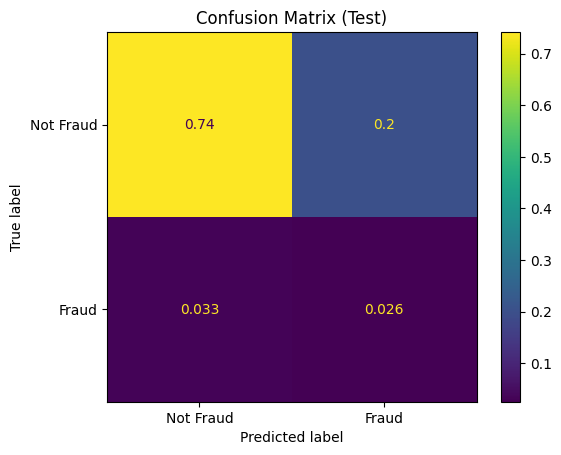

In [39]:
print(f'Accuracy score: {accuracy_score(y_train_resampled, y_train_predict)}')
print(f'precision_score: {precision_score(y_train_resampled, y_train_predict)}')
print(f'recall_score: {recall_score(y_train_resampled, y_train_predict)}')

print(f'Accuracy score_test: {accuracy_score(y_test, y_test_predict)}')
print(f'precision_score_test: {precision_score(y_test, y_test_predict)}')
print(f'recall_score_test: {recall_score(y_test, y_test_predict)}')
print(f'Test F1 Score: {f1_score(y_test, y_test_predict)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, y_test_predict)}')


cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_predict, normalize='all'),
                            display_labels=['Not Fraud', 'Fraud']
                            )

cm.plot()

plt.title('Confusion Matrix (Test)')
plt.show()